<a href="https://colab.research.google.com/github/sultankeles/Breast_Cancer_Diagnosis/blob/main/Breast_Cancer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Upload Dataset**

## 1.1. Extract .zip file retrieved from drive

In [1]:
!pip install -q gdown

In [2]:
import zipfile
import gdown
import os

# Define file ID and output paths
file_id = "1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4"
zip_output = "INbreast_Release.zip"
extract_to = "/content/INbreast_Extracted"

# Download zip from Google Drive
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_output, quiet=False)

# Extract the zip file
with zipfile.ZipFile(zip_output, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("ZIP file downloaded and extracted successfully.")

Downloading...
From (original): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4
From (redirected): https://drive.google.com/uc?id=1746ML0cBtTYZb-O-kQ39gd9GfhvW0kt4&confirm=t&uuid=47ad321a-045f-45f8-9f4a-0a822abdb795
To: /content/INbreast_Release.zip
100%|██████████| 2.01G/2.01G [00:43<00:00, 46.4MB/s]


ZIP file downloaded and extracted successfully.


In [3]:
dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"

## 1.2. Convert a DICOM file to a normalized JPG image

In [4]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.2 MB/s eta 0:00:00


In [51]:
import pydicom
import cv2
import numpy as np
import os
from tqdm import tqdm

dicom_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs"
jpg_output_dir = "/content/JPGs"
os.makedirs(jpg_output_dir, exist_ok=True)

def convert_dicom_to_jpg(dicom_path, jpg_path):
    dcm = pydicom.dcmread(dicom_path)
    img = dcm.pixel_array.astype(float)

    # Normalize to 0–255
    img = (np.maximum(img, 0) / img.max()) * 255.0
    img = np.uint8(img)

    # Save
    cv2.imwrite(jpg_path, img)

# Conversion process
for filename in tqdm(os.listdir(dicom_dir)):
    if filename.endswith(".dcm"):
        file_id = filename.split("_")[0]  # Leading number (matches File Name in the CSV)
        dicom_path = os.path.join(dicom_dir, filename)
        jpg_path = os.path.join(jpg_output_dir, f"{file_id}.jpg")
        convert_dicom_to_jpg(dicom_path, jpg_path)

print("All DICOM files have been converted to JPG format.")

100%|██████████| 412/412 [00:44<00:00,  9.18it/s]

All DICOM files have been converted to JPG format.


## 1.3. ROI (tumor regions) are output as XML → JSON

In [6]:
import xml.etree.ElementTree as ET
import os
import json
import re

xml_dir = "/content/INbreast_Extracted/INbreast Release 1.0/AllXML"
output_json_path = "/content/annotations.json"
annotations = {}

def parse_point(point_str):
    # Remove parentheses and split into float x, y
    x, y = re.findall(r"[\d.]+", point_str)
    return {"x": int(float(x)), "y": int(float(y))}

for file in os.listdir(xml_dir):
    if not file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_dir, file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_id = file.replace(".xml", "") + ".jpg"
    rois = []

    # Navigate to ROIs
    for roi_group in root.iter("array"):
        for roi in roi_group.findall("dict"):
            name = None
            points = []
            keys = list(roi)
            for i in range(len(keys)):
                if keys[i].tag == "key" and keys[i].text == "Name":
                    name = keys[i+1].text
                if keys[i].tag == "key" and keys[i].text == "Point_px":
                    # Get all point strings inside the <array>
                    px_array = keys[i+1].findall("string")
                    for p in px_array:
                        points.append(parse_point(p.text))
            if name and points:
                rois.append({
                    "label": name,
                    "points": points
                })

    if rois:
        annotations[image_id] = rois

# Save to JSON
with open(output_json_path, "w") as f:
    json.dump(annotations, f, indent=4)

print(f"Parsed {len(annotations)} images with ROI annotations.")

Parsed 343 images with ROI annotations.


# **3. Preprocessing & Augmentation**

In [52]:
import os

base_path = "/content/INbreast_Extracted/INbreast Release 1.0"

for root, dirs, files in os.walk(base_path):
    print(f"\n {root}")

    # Print subdirectories
    if dirs:
        print(f"   >Subdirectories: {dirs}")

    # Print the first 5 files
    if files:
        for f in files[:5]:
            print(f"    - {f}")


 /content/INbreast_Extracted/INbreast Release 1.0
   >Subdirectories: ['AllDICOMs', 'AllROI', 'MedicalReports', 'AllXML', 'PectoralMuscle']
    - inbreast.pdf
    - README.txt
    - INbreast.xls
    - INbreast.csv

 /content/INbreast_Extracted/INbreast Release 1.0/AllDICOMs
    - 50995789_0c735e8768d276b4_MG_R_CC_ANON.dcm
    - 24058660_9e8db9e34d5275ef_MG_R_CC_ANON.dcm
    - 50997769_cbb6c98a81e69eeb_MG_R_ML_ANON.dcm
    - 22580015_6200187f3f1ccc18_MG_R_CC_ANON.dcm
    - 53586388_dda3c6969a34ff8e_MG_R_ML_ANON.dcm

 /content/INbreast_Extracted/INbreast Release 1.0/AllROI
    - 24058738.roi
    - 53586987.roi
    - 22678856.roi
    - 24055464.roi
    - 22427705.roi

 /content/INbreast_Extracted/INbreast Release 1.0/MedicalReports
    - de4c34099d6ef8de_2010_01.txt
    - 8c105bb715bf1c3c.txt
    - 4c341dad22471922.txt
    - 3f22cdda8da215e3.txt
    - 8d0b9620c53c0268.txt

 /content/INbreast_Extracted/INbreast Release 1.0/AllXML
    - 50997134.xml
    - 22580680.xml
    - 24055806.xml
  

## 3.1. Data Reading and Review

The INbreast dataset is provided in .csv format and is separated by a semicolon (;).

Therefore, when reading the dataset with pandas, the sep=";" parameter is given.

Otherwise, the columns are separated incorrectly and the data is loaded incorrectly.

In [119]:
import pandas as pd

csv_path = "/content/INbreast_Extracted/INbreast Release 1.0/INbreast.csv"

# Use sep=";" because the file is separated with semicolons
df = pd.read_csv(csv_path, sep=";")

# Create the file name with a .jpg extension
df["filename"] = df["File Name"].astype(str) + ".jpg"

# Drop unnecessary columns and create our label set
df_clean = df[["filename", "Laterality", "View", "ACR", "Bi-Rads"]].copy()
df_clean.columns = ["filename", "laterality", "view", "acr_density", "birads_label"]

# Take a look at the first few rows
df_clean.head()

,filename,laterality,view,acr_density,birads_label
0,22678622.jpg,R,CC,4,1
1,22678646.jpg,L,CC,4,3
2,22678670.jpg,R,MLO,4,1
3,22678694.jpg,L,MLO,4,3
4,22614074.jpg,R,CC,2,5


## 3.2. BI-RADS Class Distribution

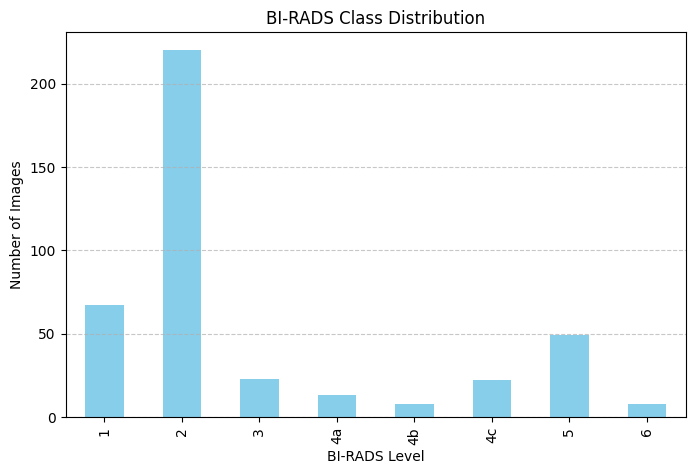

In [54]:
import matplotlib.pyplot as plt

# Count class distribution
birads_counts = df_clean["birads_label"].value_counts().sort_index()

# Visualize
plt.figure(figsize=(8, 5))
birads_counts.plot(kind="bar", color="skyblue")
plt.title("BI-RADS Class Distribution")
plt.xlabel("BI-RADS Level")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

### 3.2.1. Sorting Images into Folders Based on BI-RADS Levels

* The .jpg files were copied into folders based on their classes using the df_clean DataFrame.

* Folder names were given as: "BI-RADS-1", "BI-RADS-2", "BI-RADS-3", "BI-RADS-4a", "BI-RADS-4b", "BI-RADS-4ac", "BI-RADS-5", "BI-RADS-6".

In [55]:
import os
import shutil
from tqdm import tqdm

# Main directories
img_source_dir = "/content/JPGs"
output_dir = "/content/BI-RADS_split"
os.makedirs(output_dir, exist_ok=True)

# Copy images into folders by BI-RADS label
for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Copying images"):
    label = str(row["birads_label"]).strip()
    src_path = os.path.join(img_source_dir, row["filename"])
    class_dir = os.path.join(output_dir, f"BIRADS_{label}")
    os.makedirs(class_dir, exist_ok=True)

    dst_path = os.path.join(class_dir, row["filename"])

    try:
        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Warning: {src_path} not found.")
    except Exception as e:
        print(f"Error copying {src_path} -> {dst_path}: {e}")

Copying images: 100%|██████████| 410/410 [00:00<00:00, 738.94it/s]


In [56]:
# Count number of images per class
class_counts = {}

for class_name in sorted(os.listdir(output_dir)):
    class_path = os.path.join(output_dir, class_name)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        class_counts[class_name] = num_files

# Show
for label, count in class_counts.items():
    print(f"{label}: {count} images")

BIRADS_1: 150 images
BIRADS_2: 220 images
BIRADS_3: 150 images
BIRADS_4a: 148 images
BIRADS_4b: 149 images
BIRADS_4c: 150 images
BIRADS_5: 148 images
BIRADS_6: 150 images


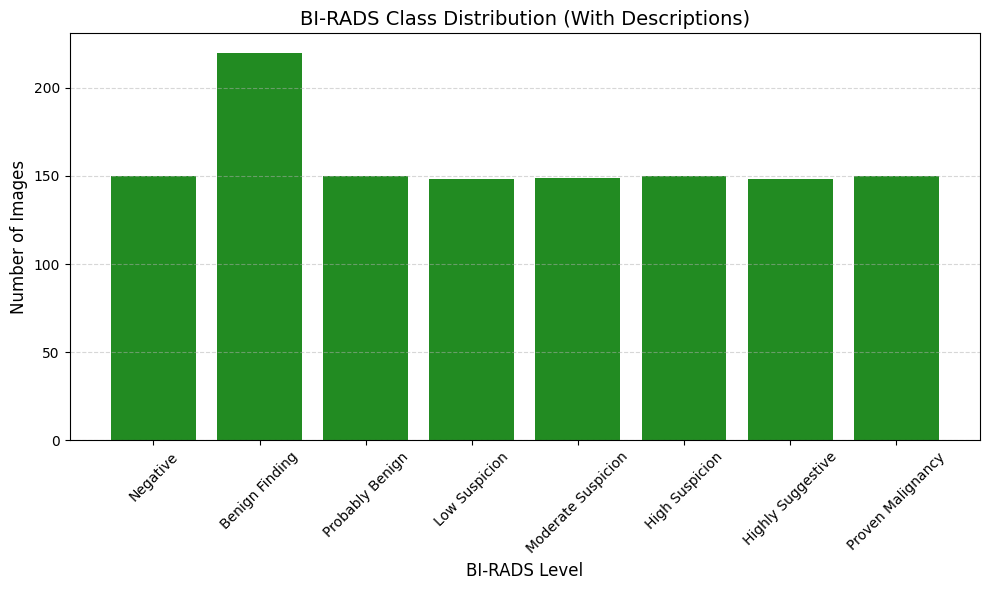

In [97]:
import matplotlib.pyplot as plt

# Label descriptions
label_map = {
    "1": "Negative",
    "2": "Benign Finding",
    "3": "Probably Benign",
    "4a": "Low Suspicion",
    "4b": "Moderate Suspicion",
    "4c": "High Suspicion",
    "5": "Highly Suggestive",
    "6": "Proven Malignancy"
}

# Helper function: BIRADS_4a → "4a"
def extract_label(folder_name):
    return folder_name.split("_")[-1].lower()

# Filter and sort folders for plotting
filtered = {k: v for k, v in class_counts.items() if k.startswith("BIRADS_")}
sorted_labels = sorted(filtered.keys(), key=lambda x: extract_label(x))

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(
    [label_map.get(extract_label(l), extract_label(l)) for l in sorted_labels],
    [filtered[l] for l in sorted_labels],
    color="forestgreen"
)
plt.title("BI-RADS Class Distribution (With Descriptions)", fontsize=14)
plt.xlabel("BI-RADS Level", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 3.3. Augmentation

Nested break statements were handled correctly.

The production count was controlled directly using a while loop.

Simplified using print instead of tqdm (can be added again if needed).

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import os

# Original folder
base_dir = "/content/BI-RADS_split"

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Target: 150 samples per class (except BIRADS_2)
target_count = 150

for class_name in sorted(os.listdir(base_dir)):
    if class_name == "BIRADS_2":
        continue  # no augmentation for this class

    class_path = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(".jpg")]
    current_count = len(images)
    to_generate = target_count - current_count

    print(f" {class_name}: {current_count} → {target_count} (augment: {to_generate})")

    if to_generate <= 0:
        continue

    generated = 0
    while generated < to_generate:
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            for batch in datagen.flow(x, batch_size=1,
                                       save_to_dir=class_path,
                                       save_prefix="aug",
                                       save_format="jpg"):
                generated += 1
                if generated >= to_generate:
                    break
            if generated >= to_generate:
                break

 BIRADS_1: 150 → 150 (augment: 0)
 BIRADS_3: 150 → 150 (augment: 0)
 BIRADS_4a: 148 → 150 (augment: 2)
 BIRADS_4b: 149 → 150 (augment: 1)
 BIRADS_4c: 150 → 150 (augment: 0)
 BIRADS_5: 148 → 150 (augment: 2)
 BIRADS_6: 150 → 150 (augment: 0)


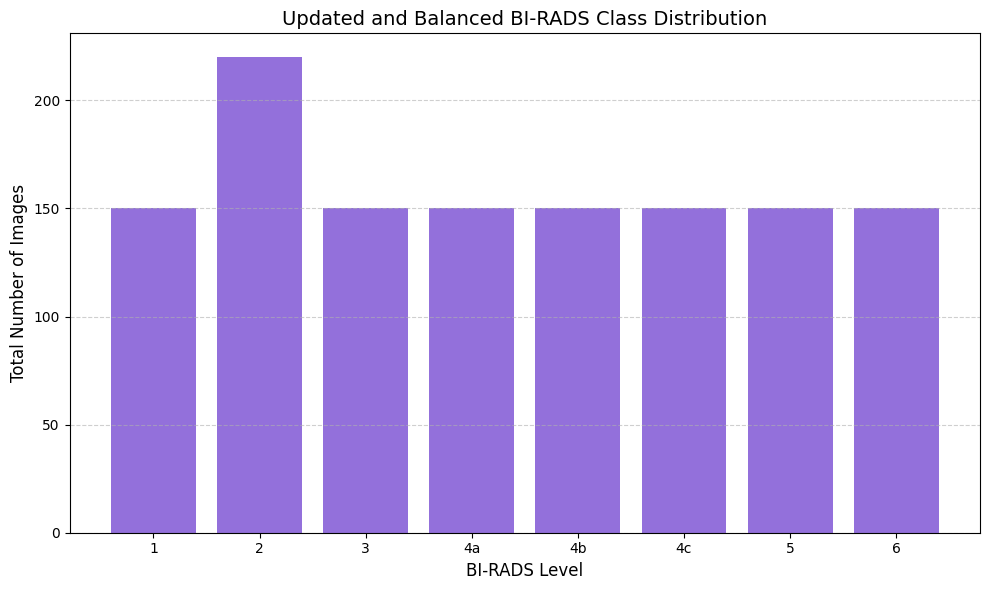

In [59]:
import matplotlib.pyplot as plt
import os

# Path to the updated (augmented) folder
augmented_base_dir = "/content/BI-RADS_split"

# Get updated image counts per class
birads_counts_clean = {}
for class_name in sorted(os.listdir(augmented_base_dir)):
    class_dir = os.path.join(augmented_base_dir, class_name)
    if os.path.isdir(class_dir):
        count = len([f for f in os.listdir(class_dir) if f.endswith(".jpg")])
        birads_counts_clean[class_name] = count

# X-axis labels
x_labels = [label.split("_")[-1] for label in birads_counts_clean.keys()]
y_counts = list(birads_counts_clean.values())

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_counts, color="mediumpurple")
plt.title("Updated and Balanced BI-RADS Class Distribution", fontsize=14)
plt.xlabel("BI-RADS Level", fontsize=12)
plt.ylabel("Total Number of Images", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# **4. Dataset Preparation for Model Training**

Scan the BI-RADS_split directory.

Retrieve the full path and label of each image.

Store them in a DataFrame.

Then split using train_test_split.

In [120]:
import os
import pandas as pd

base_dir = "/content/BI-RADS_split"

filepaths = []
labels = []

for class_name in sorted(os.listdir(base_dir)):  # BIRADS_1, BIRADS_2, ...
    class_path = os.path.join(base_dir, class_name)  # /content/BI-RADS_split/BIRADS_1

    for fname in os.listdir(class_path):  # Get files inside BIRADS_1
        if fname.endswith(".jpg"):
            filepaths.append(os.path.join(class_path, fname))  # Save full file path
            labels.append(class_name)  # Save label (e.g., BIRADS_1)

df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

df.head(20)

,filepath,label
0,/content/BI-RADS_split/BIRADS_1/24055051.jpg,BIRADS_1
1,/content/BI-RADS_split/BIRADS_1/53586415.jpg,BIRADS_1
2,/content/BI-RADS_split/BIRADS_1/aug_0_2709.jpg,BIRADS_1
3,/content/BI-RADS_split/BIRADS_1/53581433.jpg,BIRADS_1
4,/content/BI-RADS_split/BIRADS_1/aug_0_3046.jpg,BIRADS_1
5,/content/BI-RADS_split/BIRADS_1/50998322.jpg,BIRADS_1
6,/content/BI-RADS_split/BIRADS_1/aug_0_3458.jpg,BIRADS_1
7,/content/BI-RADS_split/BIRADS_1/aug_0_7540.jpg,BIRADS_1
8,/content/BI-RADS_split/BIRADS_1/aug_0_515.jpg,BIRADS_1
9,/content/BI-RADS_split/BIRADS_1/24065308.jpg,BIRADS_1


In [61]:
from sklearn.model_selection import train_test_split

# Step 1: train + temp
df_train, df_temp = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)

# Step 2: val + test (from temp)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

# Check: size of each set
print(f"Train: {len(df_train)}")
print(f"Validation: {len(df_val)}")
print(f"Test: {len(df_test)}")

Train: 889
Validation: 190
Test: 191


# **5. Custom CNN Model**

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalization for all sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Common parameters
img_size = (128, 128)
batch_size = 32

# Data flows
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='filepath',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 889 validated image filenames belonging to 8 classes.
Found 190 validated image filenames belonging to 8 classes.
Found 191 validated image filenames belonging to 8 classes.


## 5.1. Custom CNN Architecture

      Layer                     Description
    3 x Conv2D         Deep feature extraction with increasing number of filters  
    MaxPooling2D       Reduces dimensions, concentrates information  
    Flatten            Converts the image into a vector  
    Dense (128)        Fully connected layer responsible for learning  
    Dropout (0.5)      Protection against overfitting  
    Dense (8)          Softmax output for 8 classes  


In [64]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Input shape
input_shape = (128, 128, 3)
num_classes = len(train_gen.class_indices)

# Model architecture
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,712 (16.36 MB)

 Trainable params: 4,288,712 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

      Callback                   What It Does
    EarlyStopping              Stops training early if validation performance doesn't improve
    ModelCheckpoint            Saves the model with the best validation performance as a .h5 file

> restore_best_weights=True → Restores the best epoch’s weights at the end of training

> save_best_only=True → Saves only the best model to the .h5 file

> patience=5 → Stops if there is no improvement for 5 consecutive epochs

In [66]:
# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     # or 'val_accuracy'
    patience=5,             # stops if no improvement for 5 epochs
    restore_best_weights=True
)

In [65]:
# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_model.keras",        # Filename to save the best model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [68]:
# Training
import time
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=50,  # Can be higher since training will stop early if needed
    batch_size = 32,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

end = time.time()
total_seconds = end - start_time
minutes = total_seconds // 60
seconds = total_seconds % 60
print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.2974 - loss: 1.8920

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.68648, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 576ms/step - accuracy: 0.2974 - loss: 1.8914 - val_accuracy: 0.4105 - val_loss: 1.6865
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.3558 - loss: 1.7232
Epoch 2: val_loss improved from 1.68648 to 1.51856, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 515ms/step - accuracy: 0.3563 - loss: 1.7217 - val_accuracy: 0.4158 - val_loss: 1.5186
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.4437 - loss: 1.5176
Epoch 3: val_loss improved from 1.51856 to 1.36523, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 535ms/step - accuracy: 0.4438 - loss: 1.5171 - val_accuracy: 0.5368 - val_loss: 1.3652
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.5142 - loss: 1.3734
Epoch 4: val_loss improved from 1.36523 to 1.21918, saving model to best_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 14s 514ms/step - accurac

In [23]:
model.load_weights("best_model.keras")

loss, acc = model.evaluate(test_gen)
print(f"\n Test Accuracy: {acc:.4f} - Test Loss: {loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 474ms/step - accuracy: 0.7680 - loss: 0.8273

 Test Accuracy: 0.7579 - Test Loss: 0.8576


## 5.2. Confusion Matrix & Classification Report

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 582ms/step


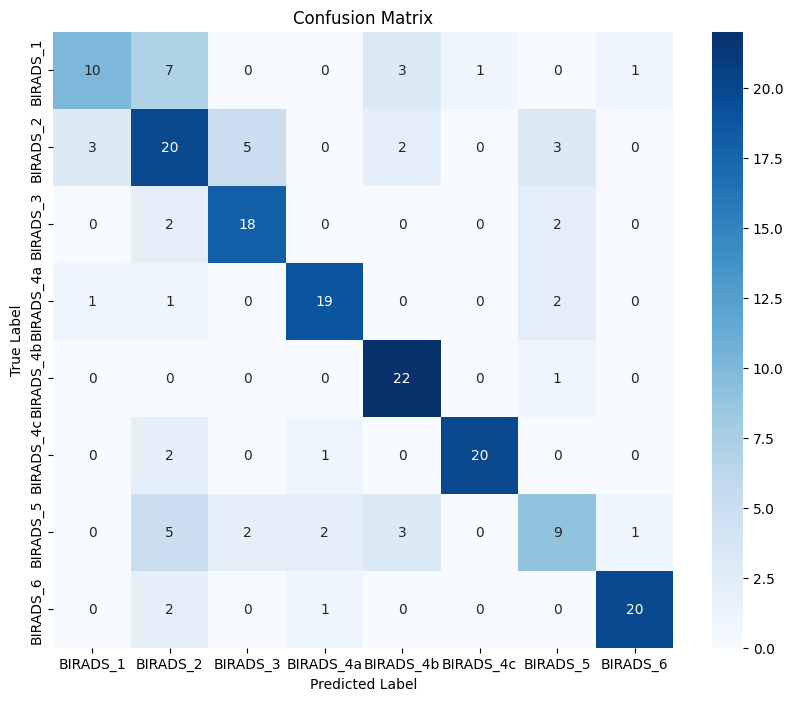

              precision    recall  f1-score   support

    BIRADS_1       0.71      0.45      0.56        22
    BIRADS_2       0.51      0.61      0.56        33
    BIRADS_3       0.72      0.82      0.77        22
   BIRADS_4a       0.83      0.83      0.83        23
   BIRADS_4b       0.73      0.96      0.83        23
   BIRADS_4c       0.95      0.87      0.91        23
    BIRADS_5       0.53      0.41      0.46        22
    BIRADS_6       0.91      0.87      0.89        23

    accuracy                           0.72       191
   macro avg       0.74      0.73      0.72       191
weighted avg       0.73      0.72      0.72       191



In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# True labels
y_true = test_gen.classes

# Predicted labels
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_names = list(test_gen.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=False)
print(report)

## 5.3. Accuracy/Loss grafikleri

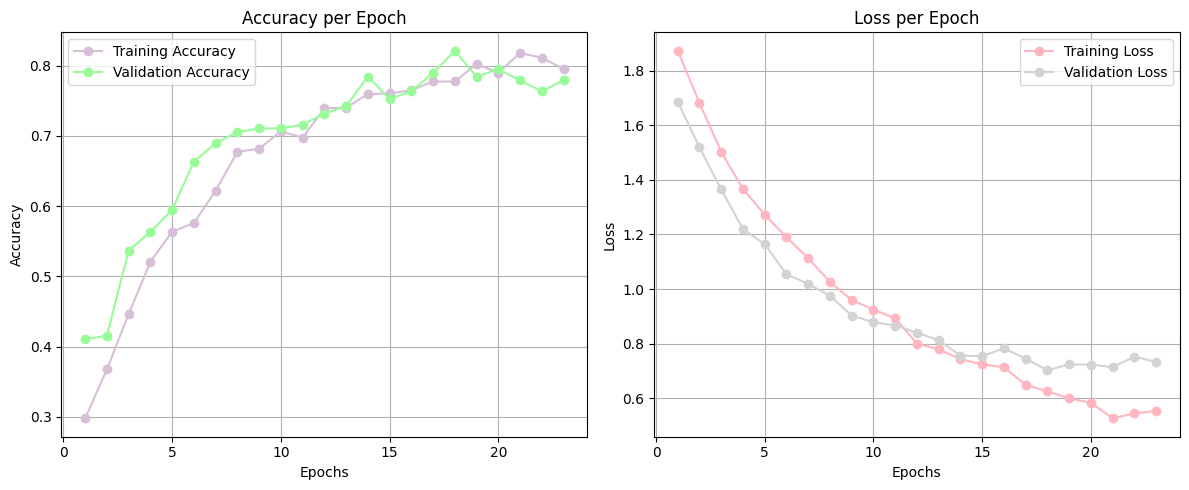

In [98]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, color='thistle', marker='o', label='Training Accuracy')
plt.plot(epochs, val_acc, color='palegreen', marker='o', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, color='lightpink', marker='o', label='Training Loss')
plt.plot(epochs, val_loss, color='lightgray', marker='o', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## 5.4. Prediction

Select a few random images from the test set.

Display both the model’s predicted class and the true class.

Show the images along with the predicted labels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


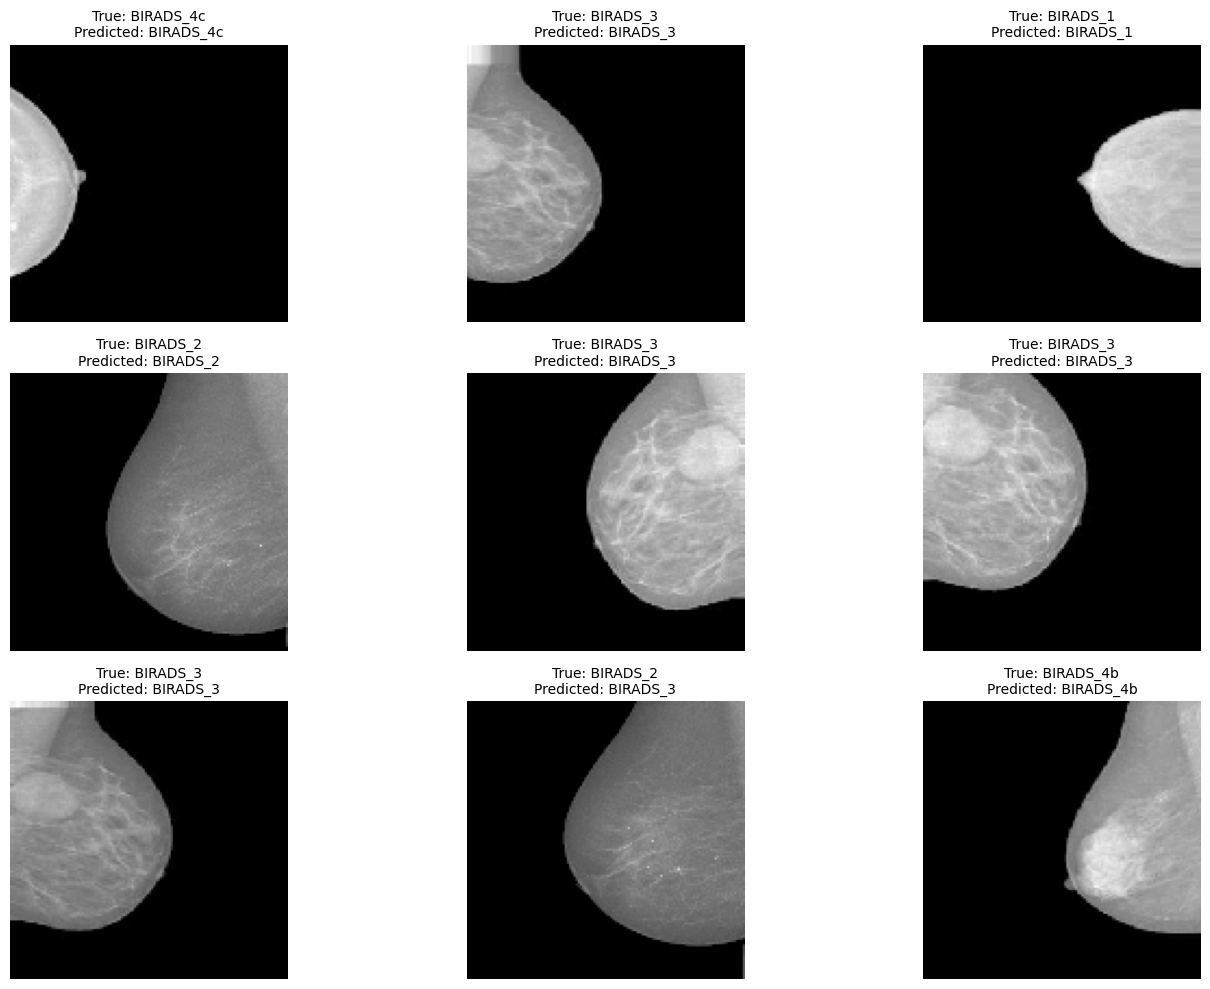

In [71]:
import random
from tensorflow.keras.preprocessing import image

# Class names and indices
class_names = list(test_gen.class_indices.keys())

# Select 9 random examples
plt.figure(figsize=(15, 10))
for i in range(9):
    index = random.randint(0, len(test_gen.filenames)-1)
    img_path = test_gen.filepaths[index]
    true_label = class_names[y_true[index]]

    # Load image
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    pred_probs = model.predict(img_array)
    pred_label = class_names[np.argmax(pred_probs)]

    # Display
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True: {true_label}\nPredicted: {pred_label}", fontsize=10)

plt.tight_layout()
plt.show()

## 5.5. Draw ROI

In [72]:
pip install roifile

In [108]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Risk order of BI-RADS classes
birads_order = ['1', '2', '3', '4a', '4b', '4c', '5', '6']

# Normalization (values between 0 and 1)
birads_normalized = {label: i / (len(birads_order)-1) for i, label in enumerate(birads_order)}

# Color map: green to red (higher risk → more red)
cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red

# Get color based on class label
def get_color_from_birads(label):
    if label not in birads_normalized:
        return "gray"
    return mcolors.to_hex(cmap(birads_normalized[label]))

# Determine color based on prediction correctness
def get_roi_color_by_truth(true_label=None, pred_label=None):
    if true_label is None:
        return "mediumpurple"
    if pred_label != true_label:
        return "black"  # wrong prediction → black
    return get_color_from_birads(true_label)

# Generate color palette for each class
color_palette = {label: get_color_from_birads(label) for label in birads_order}
color_palette

<ipython-input-108-1962c5b44f26>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn_r')  # reversed: 1 = green, 6 = red


{'1': '#006837',
 '2': '#39a758',
 '3': '#9dd569',
 '4a': '#e3f399',
 '4b': '#fee999',
 '4c': '#fca55d',
 '5': '#e34933',
 '6': '#a50026'}

In [109]:
# ROI Drawing: Advanced version (gradient color, blue for incorrect, area calculation, with saving)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

# Function to calculate polygon area
def calculate_polygon_area(points):
    """
    Calculates the area of a polygon using the Shoelace formula.
    """
    x = [p["x"] for p in points]
    y = [p["y"] for p in points]
    area = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
    return area

# Draw ROI with approximate polygon area and color palette
def draw_roi_with_palette(img_path, image_id, annotations, true_label=None, pred_label=None, save_dir=None):
    from matplotlib.patches import Rectangle

    # Load image
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    # ROI data
    rois = annotations.get(image_id, [])
    total_area = 0

    # Create figure and axes: 1x2 grid (left: image, right: color palette)
    fig, (ax_img, ax_legend) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
    ax_img.imshow(img_np)

    for roi in rois:
        points = roi["points"]
        if len(points) < 3:
            continue
        poly_coords = [(p["x"], p["y"]) for p in points]
        area = calculate_polygon_area(points)
        total_area += area

        color = get_roi_color_by_truth(true_label, pred_label)
        polygon = patches.Polygon(
            poly_coords,
            closed=True,
            edgecolor=color,
            facecolor=color,
            alpha=0.3,
            linewidth=2
        )
        ax_img.add_patch(polygon)

    # Title and display settings
    title = f"True: {true_label or 'Unknown'}  Predicted: {pred_label or 'Unknown'}\n"
    title += f"ROI Area: {int(total_area)} pixels²"
    ax_img.set_title(title, fontsize=12)
    ax_img.axis("off")

    # Palette layout settings
    box_height = 0.6
    spacing = 0.15

    extra_items = 2  # Misestimation + Unknown
    total_items = len(birads_order) + extra_items
    full_height = total_items * (box_height + spacing)

    ax_legend.set_xlim(0, 1)
    ax_legend.set_ylim(0, full_height)
    ax_legend.axis("off")

    # Draw palette boxes
    for i, label in enumerate(birads_order):
        y = i * (box_height + spacing)
        color = get_color_from_birads(label)
        ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color=color))
        ax_legend.text(0.55, y + box_height / 2, f"BI-RADS {label}", va='center', ha='left', fontsize=10)

    # Misestimation box (black)
    y = len(birads_order) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="black"))
    ax_legend.text(0.55, y + box_height / 2, "Misestimation", va='center', ha='left', fontsize=10)

    # Unknown box (purple)
    y = (len(birads_order) + 1) * (box_height + spacing)
    ax_legend.add_patch(Rectangle((0.1, y), 0.4, box_height, color="mediumpurple"))
    ax_legend.text(0.55, y + box_height / 2, "Unknown", va='center', ha='left', fontsize=10)

    plt.tight_layout()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, image_id.replace(".jpg", "_with_palette.png"))
        plt.savefig(out_path)
        plt.close()
    else:
        plt.show()


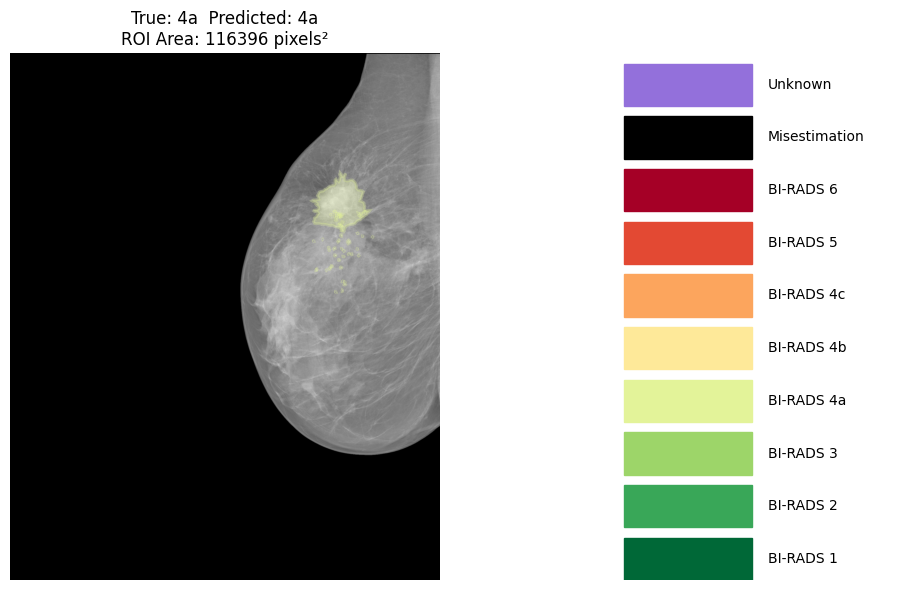

In [127]:
import random

# Filter images that contain ROIs with polygons having at least 3 points
valid_ids_with_polygon = [
    k for k, v in annotations.items()
    if any(len(roi["points"]) >= 3 for roi in v)
]

# Select a random sample
sample_id = random.choice(valid_ids_with_polygon)
img_path = f"/content/JPGs/{sample_id}"

# Randomly assign true and predicted labels (for testing purposes)
true_label = random.choice(birads_order)
pred_label = random.choice(birads_order)

# Draw the enhanced ROI visualization with color palette
draw_roi_with_palette(
    img_path=img_path,
    image_id=sample_id,
    annotations=annotations,
    true_label=true_label,
    pred_label=pred_label,
    save_dir=None
)

# **6. DenseNet121**

>DenseNet121 Training Workflow

* Model Preparation

Load DenseNet121 with ImageNet weights

Customize the top layers (classification head) according to our own classes

* Training Setup

Loss function, optimizer, metrics

EarlyStopping + ModelCheckpoint (as before)

* Training & Evaluation

Start training

Monitor validation and test accuracy

Generate Confusion Matrix and Classification Report

## 6.1. Feature Extraction

DenseNet121 was loaded with pre-trained weights from ImageNet.

The base model (feature extractor) was frozen (base_model.trainable = False).

The following layers were added on top:

GlobalAveragePooling2D

Dropout

Dense + Dropout

Softmax (for output)

Only the newly added layers were trained.

The model was compiled with the Adam optimizer, appropriate loss function, and accuracy metric.

During training:

EarlyStopping

ModelCheckpoint were used.

In [85]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Input shape
input_shape = (128, 128, 3)
num_classes = 8  # BIRADS_1 to BIRADS_6 + 4a, 4b, 4c

# Pretrained DenseNet121 (ImageNet) + freeze base
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # In the first phase, only the top layers will be trained

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Define the model
densenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
densenet_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,736 (27.35 MB)

 Trainable params: 132,232 (516.53 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ModelCheckpoint
checkpoint = ModelCheckpoint(
    "best_densenet_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

### 6.1.1 Fitting

In [36]:
import time
start = time.time()

history_densenet = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    batch_size = 32,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8652 - loss: 0.4356
Epoch 1: val_loss improved from inf to 0.43620, saving model to best_densenet_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 650ms/step - accuracy: 0.8650 - loss: 0.4354 - val_accuracy: 0.8421 - val_loss: 0.4362
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8543 - loss: 0.4457
Epoch 2: val_loss did not improve from 0.43620
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 537ms/step - accuracy: 0.8543 - loss: 0.4455 - val_accuracy: 0.8421 - val_loss: 0.4417
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.8315 - loss: 0.4614
Epoch 3: val_loss did not improve from 0.43620
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 592ms/step - accuracy: 0.8320 - loss: 0.4607 - val_accuracy: 0.8421 - val_loss: 0.4377
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8575 - loss: 0.4220
Epoch 4: val_loss did not improve from 0.43620
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 530ms/step - accuracy: 0.8572 - loss: 0.

In [87]:
from tensorflow.keras.models import load_model

# Load the best saved model
best_densenet_model = load_model("best_densenet_model.keras")

# Evaluate on the test set
test_loss, test_acc = best_densenet_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8380 - loss: 0.4444
Test Accuracy: 0.8220


### 6.2.2. Confusion Matrix & Classification Report

6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
              precision    recall  f1-score   support

    BIRADS_1       0.67      0.55      0.60        22
    BIRADS_2       0.52      0.79      0.63        33
    BIRADS_3       0.95      0.91      0.93        22
   BIRADS_4a       1.00      0.96      0.98        23
   BIRADS_4b       0.96      0.96      0.96        23
   BIRADS_4c       0.95      0.91      0.93        23
    BIRADS_5       0.93      0.64      0.76        22
    BIRADS_6       1.00      0.87      0.93        23

    accuracy                           0.82       191
   macro avg       0.87      0.82      0.84       191
weighted avg       0.85      0.82      0.83       191



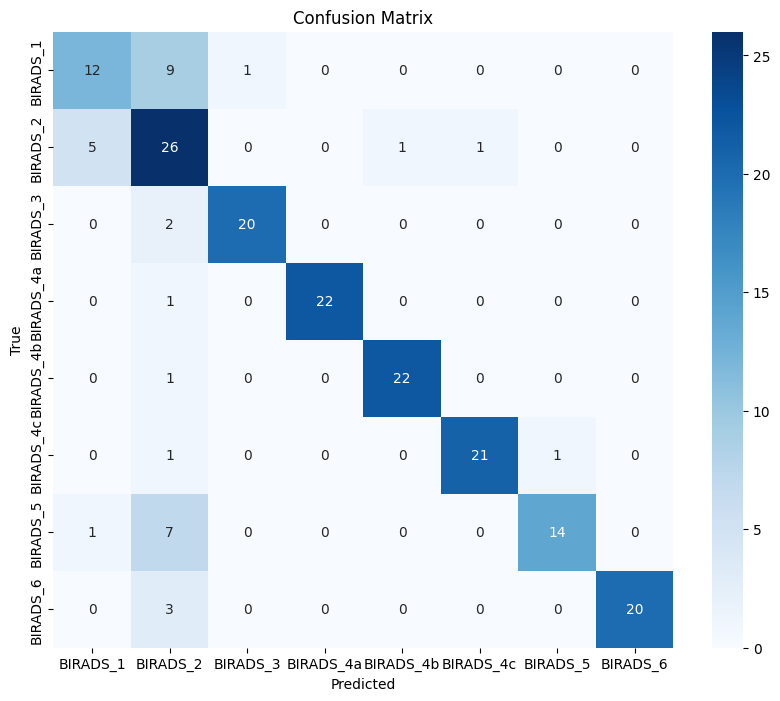

In [88]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = best_densenet_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Class label names
class_labels = list(test_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 6.2. Fine-Tuning

Make the base model’s layers trainable again.

Recompile the model with a lower learning rate (lr=1e-5).

Retrain the model using early stopping and model checkpoints.

In [94]:
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-30:]:  # Adjust number of layers to unfreeze
    layer.trainable = True

# Compile with a low learning rate
densenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Added LR scheduler to Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Train
fine_tune_history = densenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8869 - loss: 0.3996
Epoch 1: val_loss improved from 1.12844 to 1.02547, saving model to best_densenet_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.8874 - loss: 0.3989 - val_accuracy: 0.6947 - val_loss: 1.0255 - learning_rate: 1.0000e-05
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9258 - loss: 0.3102
Epoch 2: val_loss improved from 1.02547 to 0.91207, saving model to best_densenet_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 578ms/step - accuracy: 0.9257 - loss: 0.3105 - val_accuracy: 0.7316 - val_loss: 0.9121 - learning_rate: 1.0000e-05
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9440 - loss: 0.2761
Epoch 3: val_loss improved from 0.91207 to 0.87205, saving model to best_densenet_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 579ms/step - accuracy: 0.9442 - loss: 0.2756 - val_accuracy: 0.7526 - val_loss: 0.8720 - learning_rate: 1.0000e-05
Epoch 4/20
28/28 ━━━━━━━━━━

In [95]:
# Overall performance on the test set
test_loss, test_acc = densenet_model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8012 - loss: 0.6440
Test Accuracy: 0.8168
Test Loss: 0.6069


6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
              precision    recall  f1-score   support

    BIRADS_1       0.71      0.45      0.56        22
    BIRADS_2       0.52      0.94      0.67        33
    BIRADS_3       1.00      0.86      0.93        22
   BIRADS_4a       1.00      0.96      0.98        23
   BIRADS_4b       1.00      0.96      0.98        23
   BIRADS_4c       1.00      0.91      0.95        23
    BIRADS_5       0.83      0.45      0.59        22
    BIRADS_6       1.00      0.91      0.95        23

    accuracy                           0.82       191
   macro avg       0.88      0.81      0.83       191
weighted avg       0.86      0.82      0.82       191



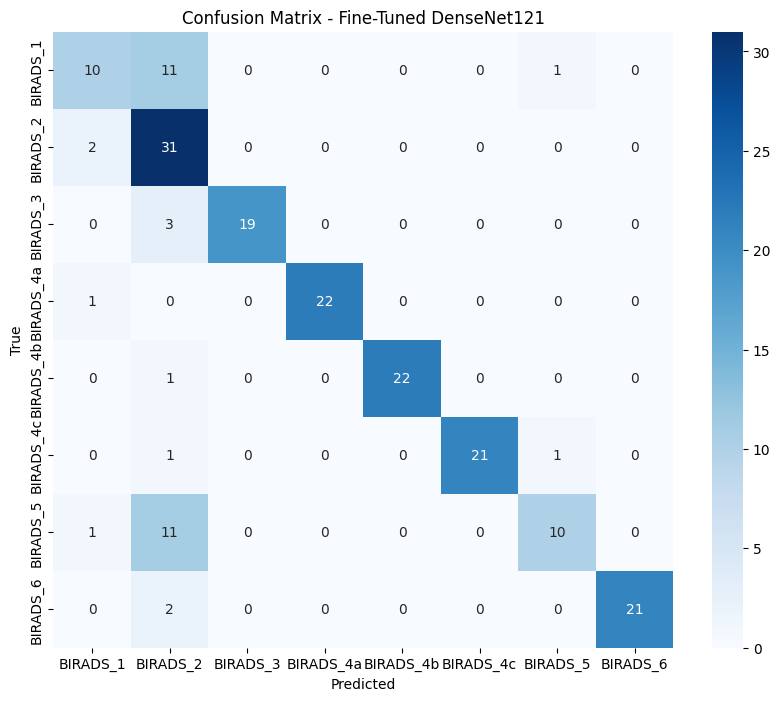

In [96]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_probs = densenet_model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Fine-Tuned DenseNet121')
plt.show()

# **7. VGG16**

## 7.1. Feature Extraction

In [93]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)
num_classes = 8

# Base model (VGG16) + freeze
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Feature extraction

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
output = Dense(num_classes, activation='softmax')(x)

# Define the model
vgg_model = Model(inputs=base_model.input, outputs=output)

# Compile
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

vgg_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 7.2. Training

In [47]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_vgg16_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [49]:
import time

start = time.time()

history_vgg = vgg_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stop, checkpoint]
)
end = time.time()
total_seconds = end - start
minutes = total_seconds // 60
seconds = total_seconds % 60

print(f"Training time: {int(minutes)} minutes {int(seconds)} seconds")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7615 - loss: 0.9961
Epoch 1: val_loss improved from 0.87354 to 0.86029, saving model to best_vgg16_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 575ms/step - accuracy: 0.7612 - loss: 0.9962 - val_accuracy: 0.8368 - val_loss: 0.8603
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7883 - loss: 0.9530
Epoch 2: val_loss improved from 0.86029 to 0.84926, saving model to best_vgg16_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 549ms/step - accuracy: 0.7879 - loss: 0.9536 - val_accuracy: 0.8421 - val_loss: 0.8493
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.7595 - loss: 0.9898
Epoch 3: val_loss improved from 0.84926 to 0.83895, saving model to best_vgg16_model.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 522ms/step - accuracy: 0.7596 - loss: 0.9891 - val_accuracy: 0.8368 - val_loss: 0.8390
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.7571 - loss: 0.9717
Epoch 4: val_loss improve

## 7.3. Testing

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.8446 - loss: 0.6472
Test Accuracy: 0.8474
Test Loss: 0.6310


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step
              precision    recall  f1-score   support

    BIRADS_1       0.76      0.59      0.67        22
    BIRADS_2       0.59      0.88      0.71        33
    BIRADS_3       0.95      0.86      0.90        22
   BIRADS_4a       1.00      0.91      0.95        23
   BIRADS_4b       0.84      0.91      0.88        23
   BIRADS_4c       1.00      0.91      0.95        23
    BIRADS_5       1.00      0.86      0.93        22
    BIRADS_6       1.00      0.82      0.90        22

    accuracy                           0.85       190
   macro avg       0.89      0.84      0.86       190
weighted avg       0.88      0.85      0.85       190



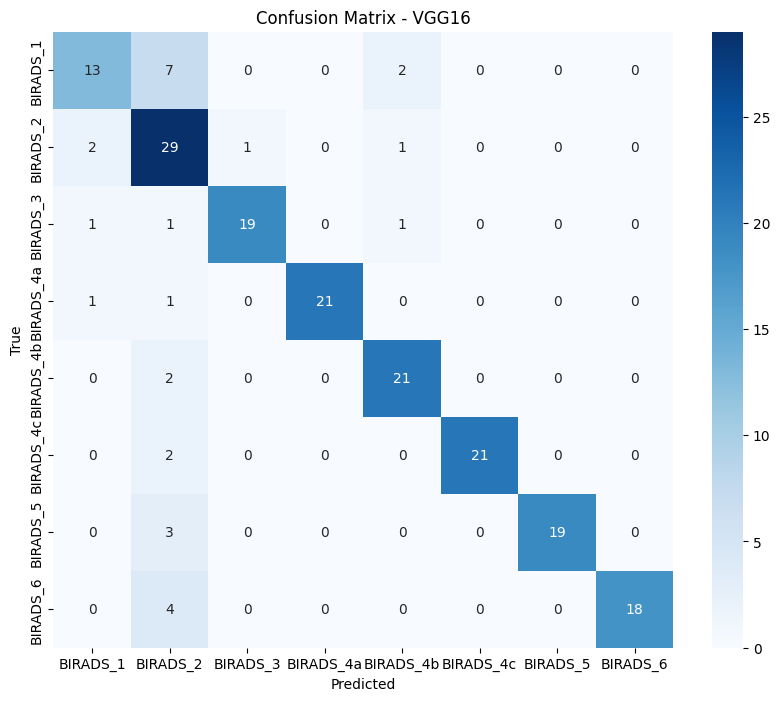

In [50]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
vgg_model_best = load_model("best_vgg16_model.keras")

# Test results
test_loss, test_acc = vgg_model_best.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = vgg_model_best.predict(test_gen)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred_labels, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - VGG16")
plt.show()